In [1]:
# Imports
import pandas as pd
import numpy as np
import nltk
import string
import re
from nltk.stem import PorterStemmer 
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, AdaBoostClassifier, StackingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import unquote
from sklearn.model_selection import RandomizedSearchCV


[nltk_data] Downloading package stopwords to /Users/sasha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

# Data Exploration

In [3]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The features available are `id`, `keyword`, `location`, `text`. The target feature is called `target` and takes on a value of 0 or 1. A value of 0 indicates that the provided tweet does not describe an actual natural disaster. A value of 1 indicates that the provided tweet does describe an actual natural disaster.

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


We are presented with a problem here: `keyword` has 61 null entries and `location` has 2,533 null entries. We can explore different strategies to handle these missing values. We can try

 - Replacing the null `keyword` values with a string such as "undefined" or "unknown", or even the empty string ""
 - Drop the keyword feature altogether

The `id` column is redundant because it does not provide us with any information about the tweet

In [5]:
# Drop id column
train_data = train_data.drop(columns=["id"])
train_data.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Missing Values
Let's investigate the missing values further.

In [6]:
print(f'Number of keywords missing in training data: {len(train_data[train_data["keyword"].isna()])}')

Number of keywords missing in training data: 61


We don't want to drop the keyword column because it provides important information about the text.

In [7]:
# Replace missing keywords with empty string
train_data.fillna({"keyword": "unknown", "location": "unknown"}, inplace=True)
train_data.head()

,keyword,location,text,target
0,unknown,unknown,Our Deeds are the Reason of this #earthquake M...,1
1,unknown,unknown,Forest fire near La Ronge Sask. Canada,1
2,unknown,unknown,All residents asked to 'shelter in place' are ...,1
3,unknown,unknown,"13,000 people receive #wildfires evacuation or...",1
4,unknown,unknown,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
# Ensure that there are no more null values for the keyword
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7613 non-null   object
 1   location  7613 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 238.0+ KB


As for `location`, that column may not be as important as the `keyword` column since natural disasters can happen anywhere. We will drop the `location` column for now.

In [9]:
# # Make a copy of original train_data
# train_data = train_data.drop(columns=["location"])
# train_data.info()

In [10]:
# A function to clean data
def clean_text(text):
    text = unquote(text)
    text = re.sub(r'http\S+', '', text)  # remove links
    text = re.sub(r'@\w+', '', text)  # remove tags/mentions
    text = re.sub(r'#(\w+)', r'\1', text) # remove hashtags
    text = text.lower().strip()
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

# Text Processing
We can create a few pipelines to explore different text preprocessing techniques.
At base, we will remove stop words from the `text` column.

In [11]:
# Clean text
train_data["cleaned_text"] = train_data['text'].map(lambda x: clean_text(x))
test_data["cleaned_text"] = test_data['text'].map(lambda x: clean_text(x))

In [12]:
train_data["cleaned_keyword"] = train_data['keyword'].map(lambda x: clean_text(x))
test_data["cleaned_keyword"] = test_data['keyword'].map(lambda x: clean_text(str(x)))

In [13]:
train_data.head()

,keyword,location,text,target,cleaned_text,cleaned_keyword
0,unknown,unknown,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us,unknown
1,unknown,unknown,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask. canada,unknown
2,unknown,unknown,All residents asked to 'shelter in place' are ...,1,resid ask 'shelter place' notifi officers. eva...,unknown
3,unknown,unknown,"13,000 people receive #wildfires evacuation or...",1,"13,000 peopl receiv wildfir evacu order califo...",unknown
4,unknown,unknown,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...,unknown


In [14]:
train_data['combined_text'] = train_data['cleaned_text'] + ' ' + train_data['cleaned_keyword']
test_data['combined_text'] = test_data['cleaned_text'] + ' ' + test_data['cleaned_keyword']

In [15]:
from sklearn.model_selection import train_test_split
X = train_data["combined_text"]
y = train_data["target"]
X_test = test_data["combined_text"]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [16]:
# Apply TF-IDF Vectorization
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_val = tfidf.transform(X_val)
X_test = tfidf.transform(X_test)

In [17]:
# Check for class imbalance
train_data["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

The classes are fairly balanced, so we will not perform any additional sampling.

In [18]:
X_train.shape

(6090, 11550)

In [19]:
X_val.shape

(1523, 11550)

## Summary of data preprocessing
- Dropped `id` column (redundant)
- Replaced missing values in `keyword` and `location` columns to "unknown"
- Cleaned each text value to remove anything we may see in tweets such as links, mentions/tags (@), hashtags (#), removing 
  stop words, stemming the words, and removing puncuation.
- Split the data into train and validation set.
- Perform tf-idf vectorization
  - fit the tf-idf vectorizer on the train data, then transform validation and test set.

# Models

The models I will train and the paramters to tune
 - K-Nearest Neighbors
    - k
    - distance metric
 - Naive Bayes
 - Decision Tree
    - max_depth
    - penalty metrics
 - Logistic Regression
 - Random Forest
 - Support Vector Machines (SVM)
 - Linear Regression
    

In [67]:
# Keep a dictionary to keep track of the models train, validation, and test (Kaggle score) accuracies
scores = {}

### K-Nearest Neighbors

In [62]:
# Util function for plotting decision boundaries
def plot_decision_boundaries(clf, X, y, h=0.01):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)

    sns.scatterplot(X[:, 0], X[:, 1],
                    edgecolor='black')
    plt.legend()
    plt.show()

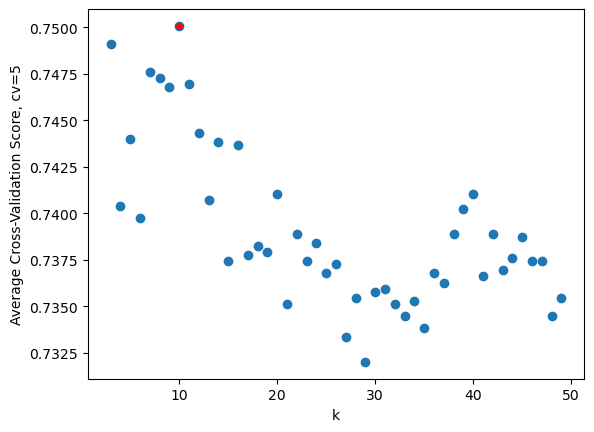

In [63]:
ks = [k for k in range(3, 50)]
avg_scores = []
for k in ks:
    clf = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    avg_scores.append(scores.mean())
max_score = max(avg_scores)
idx = avg_scores.index(max_score)
best_k = ks[idx]
plt.plot(best_k, max_score, color="red", marker="*")
plt.scatter(ks, avg_scores)
plt.xlabel("k")
plt.ylabel("Average Cross-Validation Score, cv=5")
plt.show()


In [64]:
print(f"Best k: {best_k} \nMax Average Cross Validation Score: {max_score:.2f}")

Best k: 10 
Max Average Cross Validation Score: 0.75


In [22]:
def score_clf(clf, clf_name):
    train_score = clf.score(X_train, y_train)
    val_score = clf.score(X_val, y_val)
    print(f"Training Accuracy:  {train_score}")
    print(f"Validation Accuracy: {val_score}")
    scores[clf_name] = {'train': train_score, 'val': val_score}

In [68]:
# Train knn with k = 10
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train, y_train)

# Ensure compatibility with sparse matrices for cross_val_score
train_scores = cross_val_score(clf, X_train, y_train, cv=5)

train_score = clf.score(X_train, y_train)
val_score = clf.score(X_val, y_val)

print(f"Training Accuracy: {train_score}")
print(f"Mean CV Score: {train_scores.mean():.2f}")
print(f"Validation Accuracy: {val_score}")

# Update scores dictionary
scores['knn (n=10)'] = {'train': train_score, 'val': val_score}


Training Accuracy: 0.790311986863711
Mean CV Score: 0.75
Validation Accuracy: 0.7235718975705844


In [23]:
# Uploading to Kaggle for test pred
def create_submission(X_test, clf):
    y_pred = clf.predict(X_test)
    test_submission = pd.DataFrame(
        {
            'id': test_data['id'],
            'target': y_pred
        }
    )
    test_submission.columns = test_submission.columns.str.strip()
    test_submission.to_csv("submission.csv", index=False)

In [70]:
create_submission(X_test, clf)

Kaggle Score: 0.74563

In [71]:
scores['knn (n=10)']['test'] = 0.74563

#### Why KNN Did Poorly
Using tf-idf creates many dimensions in our data, which KNN is not great at.

### Naïve Bayes

In [16]:
cv_score = cross_val_score(MultinomialNB(), X_train, y_train, cv=5)
print(f"Cross validation score for Multinomial Naive Bayes: {cv_score.mean():.2f}")

Cross validation score for Multinomial Naive Bayes: 0.79


In [74]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
train_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(f"Training Accuracy: {clf.score(X_train, y_train):.2f}")
print(f"Mean CV Score: {train_scores.mean():.2f}")
print(f"Validation Accuracy: {clf.score(X_val, y_val):.2f}")
score_clf(clf, 'multinomial NB')

Training Accuracy: 0.88
Mean CV Score: 0.80
Validation Accuracy: 0.79


In [75]:
# Create submission file for Kaggle
create_submission(X_test, clf)

Kaggle Score: 0.78823

In [76]:
scores['multinomial NB']['test'] = 0.78823

#### Naive Bayes Did Better Than KNN, but Not Great, Why?
Recall that Naïve Bayes operates under the assumption that all features are independent of one another. In high-dimensional text data such as what we have here, that assumption may not hold. Two words that appear sequentially are not independent of one another, which could explain the poor performance of the multinomial Naïve Bayes.

### Decision Trees
With decision trees, we want to experiment whether adding a `max_depth` value will improve the performance of the decision tree on the test set. Additionally, we will investigate whether the penalty metric (entropy, gini, etc) or the splitter has a significant impact on the model.

In [79]:
param_grid = {
    'splitter' : ['best', 'random'],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : [None, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}
clf = DecisionTreeClassifier(random_state=9)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 90, 'splitter': 'random'}


Based on these results, we will train our decision tree classifier with {'criterion': 'gini', 'max_depth': 90, 'splitter': 'random'}.

In [80]:
clf = DecisionTreeClassifier(random_state=9, criterion='gini', max_depth=90, splitter='random')
clf.fit(X_train, y_train)
score = clf.score(X_train, y_train)
print(f"Training Accuracy: {score:.2f}")
score = clf.score(X_val, y_val)
print(f"Validation Accuracy: {score:.2f}")

Training Accuracy: 0.91
Validation Accuracy: 0.75


The training accuracy isn't too high - so it's not overfitting too much. But the validation accuracy isn't great. Let's test some lower max_depth values to see if that improves the validation accuracy.

In [81]:
max_depths = [10, 20, 30, 40, 50, 60, 70, 80]
for depth in max_depths:
    clf = DecisionTreeClassifier(random_state=9, criterion='gini', max_depth=depth, splitter='random')
    clf.fit(X_train, y_train)
    score = clf.score(X_train, y_train)
    print(f"Training Accuracy for Max Depth = {depth}: {score:.2f}")
    score = clf.score(X_val, y_val)
    print(f"Validation Accuracy for Max Depth = {depth}: {score:.2f}")

Training Accuracy for Max Depth = 10: 0.68
Validation Accuracy for Max Depth = 10: 0.67
Training Accuracy for Max Depth = 20: 0.75
Validation Accuracy for Max Depth = 20: 0.72
Training Accuracy for Max Depth = 30: 0.79
Validation Accuracy for Max Depth = 30: 0.73
Training Accuracy for Max Depth = 40: 0.83
Validation Accuracy for Max Depth = 40: 0.74
Training Accuracy for Max Depth = 50: 0.85
Validation Accuracy for Max Depth = 50: 0.75
Training Accuracy for Max Depth = 60: 0.87
Validation Accuracy for Max Depth = 60: 0.75
Training Accuracy for Max Depth = 70: 0.89
Validation Accuracy for Max Depth = 70: 0.75
Training Accuracy for Max Depth = 80: 0.90
Validation Accuracy for Max Depth = 80: 0.75


In this case, a max depth of 50 provides the same validaton accuracy but with lower training accuracy. So we will use this value as our submission.

In [82]:
final_clf = DecisionTreeClassifier(random_state=9, criterion='gini', max_depth=50, splitter='random')
final_clf.fit(X_train, y_train)
score_clf(final_clf, 'decision tree (max_depth=50)')
create_submission(X_test, final_clf)

Training Accuracy:  0.8507389162561576
Validation Accuracy: 0.7544320420223244


Kaggle Score: 0.74747

In [83]:
scores['decision tree (max_depth=50)']['test'] = 0.74747

#### Ensemble Methods
Let's try combining many decision trees. For decision trees, these are called Random Forests.

In [20]:
# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],   # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],    # Number of features to consider when looking for the best split
    'bootstrap': [True, False]                 # Whether bootstrap samples are used when building trees
}
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [26]:
forest_clf = RandomForestClassifier(n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', 
                                    max_depth=50, bootstrap=True, n_jobs=-1, class_weight='balanced')
forest_clf.fit(X_train, y_train)
score_clf(forest_clf, 'random forest')

Training Accuracy:  0.8103448275862069
Validation Accuracy: 0.7655942219304005


In [27]:
create_submission(X_test, forest_clf)

Kaggle Score: 0.76984

The random forest classifier performed better than the plain decision tree classifier on the validation set and on the Kaggle test set. We will explore ensemble methods that combine different types of classifiers later on.

In [28]:
scores['random forest']['test'] = 0.76984

### Logistic Regression

In [ ]:
param_grid = {'penalty': ['l1', 'l2', 'elasticnet']}
clf = LogisticRegression()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

/Users/sasha/anaconda3/envs/pythoncoding/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sasha/anaconda3/envs/pythoncoding/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sasha/anaconda3/envs/pythoncoding/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sasha/anaconda3/envs/pyt

{'penalty': 'l2'}

`l2` penalty performed the best so we will fit our classifier with that parameter.

In [32]:
clf = LogisticRegression(penalty='l2', class_weight='balanced')
clf.fit(X_train, y_train)
score_clf(clf, 'logistic regression')

Training Accuracy:  0.8752052545155994
Validation Accuracy: 0.7839789888378201


While Logistic Regerssion slightly overfits on the training set, it scores relatively well on the validation set.

In [33]:
create_submission(X_test, clf)

Kaggle Score: 0.77505

In [34]:
scores['logistic regression']['test'] = 0.77505

Let's try using the bagging method with Logistic Regressions

In [35]:
bag_clf = BaggingClassifier(LogisticRegression(penalty='l2'), n_estimators=500, max_samples=0.25, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
score_clf(bag_clf, 'logistic regression (bagging)')

Training Accuracy:  0.8080459770114943
Validation Accuracy: 0.7583716349310571


This model overfits less than the single logisitic regression, but the performance on the validation set is worse.

### Ensemble Methods

Let's combine the classifiers we've seen so far.
 - KNN
 - Naive Bayes
 - Decision Tree
 - Logistic Regression

In [36]:
clf1 = KNeighborsClassifier(n_neighbors=22)
clf2 = DecisionTreeClassifier(max_depth=80, splitter='random')
clf3 = LogisticRegression()
ensemble_soft = VotingClassifier(estimators=[('knn', clf1), ('dt', clf2), 
                                             ('log', clf3)], voting='soft')
ensemble_soft.fit(X_train, y_train)
score_clf(ensemble_soft, 'ensemble soft')


Training Accuracy:  0.8912972085385878
Validation Accuracy: 0.778069599474721


In [37]:
ensemble_hard = VotingClassifier(estimators=[('knn', clf1), ('dt', clf2), 
                                             ('log', clf3)], voting='hard')
ensemble_hard.fit(X_train, y_train)
score_clf(ensemble_hard, 'ensemble hard')

Training Accuracy:  0.8691297208538588
Validation Accuracy: 0.7708470124753776


In [38]:
create_submission(X_test, ensemble_soft)

Kaggle Score: 0.76585

In [39]:
scores['ensemble soft']['test'] = 0.76585

In [40]:
create_submission(X_test, ensemble_hard)

Kaggle Score: 0.76769

In [41]:
scores['ensemble hard']['test'] = 0.76769

Soft voting performs better on the validation set than hard voting, but overfits slightly more.  

### LLM

I attached the `test.csv` file to ChatGPT-4o and asked it to classify each tweet as either describing a natural disaster (1) or not (0) and record the results to a csv file.

In [6]:
import pandas as pd
llm_preds = pd.read_csv("data/model_based_real_disaster_classified.csv")

In [7]:
llm_preds.head()

,id,keyword,location,text,real_disaster
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [8]:
test_submission = pd.DataFrame(
        {
            'id': llm_preds['id'],
            'target': llm_preds['real_disaster']
        }
    )
test_submission.columns = test_submission.columns.str.strip()
test_submission.to_csv("./submissions/submission.csv", index=False)

Kaggle Score: 0.79190. 


So far, the LLM performs the best, but I would have expected the model to do better. 

### AdaBoost

In [34]:
# Parameter grid for AdaBoost
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],  # Number of weak learners
    'learning_rate': [0.01, 0.1, 0.5, 1.0],   # Learning rate shrinks the contribution of each weak learner
    'estimator__max_depth': [1, 2, 3, 5, 10],  # Maximum depth of the base estimator (DecisionTreeClassifier)
    'estimator__min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'estimator__min_samples_leaf': [1, 2, 4]     # Minimum samples required to be at a leaf node
}
base_est = DecisionTreeClassifier(random_state=42)
ada = AdaBoostClassifier(base_est, random_state=42)
random_search = RandomizedSearchCV(ada, param_grid, 
                                   cv=5, scoring='accuracy', n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_params_

{'n_estimators': 50,
 'learning_rate': 1.0,
 'estimator__min_samples_split': 2,
 'estimator__min_samples_leaf': 4,
 'estimator__max_depth': 10}

In [35]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=2), n_estimators=50, learning_rate=1)
clf.fit(X_train, y_train)
score_clf(clf, 'adaboost')

Training Accuracy:  0.8331691297208539
Validation Accuracy: 0.7596848325673013


In [36]:
create_submission(X_test, clf)

Kaggle Score: 0.75727

In [37]:
scores['adaboost']['test'] = 0.75727

In [26]:
scores = {'knn (n=10)': {'train': 0.790311986863711,
  'val': 0.7235718975705844,
  'test': 0.74563},
 'multinomial NB': {'train': 0.880623973727422,
  'val': 0.7866053841103086,
  'test': 0.78823},
 'decision tree (max_depth=50)': {'train': 0.8507389162561576,
  'val': 0.7544320420223244,
  'test': 0.74747},
 'random forest': {'train': 0.9885057471264368,
  'val': 0.7747866053841103,
  'test': 0.78608},
 'stacking clf': {'train': 0.8852216748768473,
  'val': 0.778069599474721,
  'test': 0.7729},
 'logistic regression': {'train': 0.8752052545155994,
  'val': 0.7839789888378201,
  'test': 0.77505},
 'logistic regression (bagging)': {'train': 0.8080459770114943,
  'val': 0.7583716349310571},
 'ensemble soft': {'train': 0.8912972085385878,
  'val': 0.778069599474721,
  'test': 0.76585},
 'ensemble hard': {'train': 0.8691297208538588,
  'val': 0.7708470124753776,
  'test': 0.76769},
 'adaboost': {'train': 0.8889983579638752,
  'val': 0.768220617202889,
  'test': 0.76677}}

### Gradient Boosting

In [21]:
clf = GradientBoostingClassifier(max_depth=5)
clf.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5)

In [22]:
print(f"Accuracy on training set: {clf.score(X_train, y_train)}")
print(f"Accuracy on validation set: {clf.score(X_val, y_val)}")

Accuracy on training set: 0.8315270935960591
Accuracy on validation set: 0.7603414313854235


In [23]:
params = {
    'n_estimators' : [10, 50, 100, 200, 500],
    'max_depth': np.arange(3, 11),
    'subsample': np.arange(0.5, 1.0, 0.1),
    'max_features': ['sqrt', 'log2', None]

}
search = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), 
                            params, n_iter=50, cv=5, n_jobs=-1)
search.fit(X_train, y_train)
search.best_params_

{'subsample': 0.6,
 'n_estimators': 500,
 'max_features': 'sqrt',
 'max_depth': 10}

In [24]:
clf = GradientBoostingClassifier(subsample=0.6, n_estimators=500, max_features='sqrt', max_depth=10)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores.mean())

0.7735632183908046


In [27]:
clf.fit(X_train, y_train)
score_clf(clf, 'gradient boosting')

Training Accuracy:  0.9650246305418719
Validation Accuracy: 0.7708470124753776


In [28]:
create_submission(X_test, clf)

Kaggle Score: 0.77352

In [29]:
scores['gradient boosting']['test'] = 0.77352

### XGBoost

In [30]:
param_grid = {'n_estimators': [100, 200, 300, 400, 500], 
              'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
              'learning_rate': [0.001, 0.01, 0.2, 0.3]}
search = RandomizedSearchCV(XGBClassifier(random_state=42), 
                            param_grid, n_iter=50, cv=5, n_jobs=-1)
search.fit(X_train, y_train)
search.best_params_

{'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.2}

In [31]:
clf = XGBClassifier(n_estimators=400, max_depth=3, learning_rate=0.2)
clf.fit(X_train, y_train)
score_clf(clf, 'xgboost')

Training Accuracy:  0.8719211822660099
Validation Accuracy: 0.7669074195666448


In [32]:
create_submission(X_test, clf)

Kaggle Score: 0.77658

In [33]:
scores['xgboost']['test'] = 0.77658

### Stacking

In [23]:
scores = {'knn (n=10)': {'train': 0.790311986863711,
  'val': 0.7235718975705844,
  'test': 0.74563},
 'multinomial NB': {'train': 0.880623973727422,
  'val': 0.7866053841103086,
  'test': 0.78823},
 'decision tree (max_depth=50)': {'train': 0.8507389162561576,
  'val': 0.7544320420223244,
  'test': 0.74747},
 'random forest': {'train': 0.9885057471264368,
  'val': 0.7747866053841103,
  'test': 0.78608},
 'stacking clf': {'train': 0.8991789819376026, 'val': 0.7504924491135916}}

In [28]:
base_learners = [
    ('rf', RandomForestClassifier(n_jobs=-1, class_weight='balanced')),
    ('gb', GradientBoostingClassifier(max_depth=5)),
    ('log', LogisticRegression()),
    ('ada', AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=100))
]

final_model = XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.2)

stack = StackingClassifier(
    estimators=base_learners,
    final_estimator=final_model,
    cv=5  
)

stack.fit(X_train, y_train)
score_clf(stack, 'stacking clf')

Training Accuracy:  0.8852216748768473
Validation Accuracy: 0.778069599474721


In [30]:
create_submission(X_test, stack)

Kaggle Score: 0.77290

In [31]:
scores['stacking clf']['test'] = 0.77290

In [25]:
scores = {'knn (n=10)': {'train': 0.790311986863711,
  'val': 0.7235718975705844,
  'test': 0.74563},
 'multinomial NB': {'train': 0.880623973727422,
  'val': 0.7866053841103086,
  'test': 0.78823},
 'decision tree (max_depth=50)': {'train': 0.8507389162561576,
  'val': 0.7544320420223244,
  'test': 0.74747},
 'random forest': {'train': 0.9885057471264368,
  'val': 0.7747866053841103,
  'test': 0.78608},
 'stacking clf': {'train': 0.8852216748768473,
  'val': 0.778069599474721,
  'test': 0.7729},
 'logistic regression': {'train': 0.8752052545155994,
  'val': 0.7839789888378201,
  'test': 0.77505},
 'logistic regression (bagging)': {'train': 0.8080459770114943,
  'val': 0.7583716349310571},
 'ensemble soft': {'train': 0.8912972085385878,
  'val': 0.778069599474721,
  'test': 0.76585},
 'ensemble hard': {'train': 0.8691297208538588,
  'val': 0.7708470124753776,
  'test': 0.76769},
 'adaboost': {'train': 0.8889983579638752,
  'val': 0.768220617202889,
  'test': 0.76677},
 'gradient boosting': {'train': 0.9650246305418719,
  'val': 0.7708470124753776,
  'test': 0.77352},
 'xgboost': {'train': 0.8719211822660099,
  'val': 0.7669074195666448,
  'test': 0.77658}}

In [1]:
scores_df = pd.DataFrame.from_dict(scores, orient='index')
scores_df.reset_index(inplace=True)
scores_df.rename(columns={'index': 'model'}, inplace=True)

NameError: name 'pd' is not defined

In [39]:
scores_df

,model,train,val,test
0,knn (n=10),0.790312,0.723572,0.74563
1,multinomial NB,0.880624,0.786605,0.78823
2,decision tree (max_depth=50),0.850739,0.754432,0.74747
3,random forest,0.988506,0.774787,0.78608
4,stacking clf,0.885222,0.778070,0.77290
5,logistic regression,0.875205,0.783979,0.77505
6,logistic regression (bagging),0.808046,0.758372,NaN
7,ensemble soft,0.891297,0.778070,0.76585
8,ensemble hard,0.869130,0.770847,0.76769
9,adaboost,0.888998,0.768221,0.76677


In [40]:
scores_df.to_csv('data/final_model_scores.csv')